In [1]:
load('../scw/scw2016/data/cd.RData')

In [2]:
ls()

[1] "cd"

In [3]:
dim(cd)

[1] 23228   224

In [5]:
cd[1:5,1:5]

,SRR2967608,SRR2967609,SRR2967610,SRR2967611,SRR2967612
1/2-SBSRNA4,1,18,0,0,0
A1BG,0,0,2,0,0
A1BG-AS1,0,0,0,0,0
A1CF,0,0,0,0,0
A2LD1,0,0,0,0,0


In [6]:
# filter out low-gene cells (often empty wells)
cd <- cd[, colSums(cd>0)>1.8e3]
# remove genes that don't have many reads
cd <- cd[rowSums(cd)>10, ]
# remove genes that are not seen in a sufficient number of cells
cd <- cd[rowSums(cd>0)>5, ]

# how many genes and cells after filtering?
dim(cd)

[1] 12453   224

In [7]:
# transform to make more data normal
mat <- log10(as.matrix(cd)+1)
# look at snippet of data
mat[1:5, 1:5]

,SRR2967608,SRR2967609,SRR2967610,SRR2967611,SRR2967612
1/2-SBSRNA4,0.3010300,1.278754,0.0000000,0,0.000000
A1BG,0.0000000,0.000000,0.4771213,0,0.000000
A2M,0.0000000,0.000000,0.0000000,0,0.000000
A2MP1,0.0000000,0.000000,0.0000000,0,0.000000
AAAS,0.4771213,1.959041,0.0000000,0,1.361728


In [11]:
ls()

[1] "cd"  "mat"

In [15]:
# load labels
load("../scw/scw2016/data/sg.RData")

In [13]:
ls()

[1] "cd"  "mat" "sg"

In [14]:
head(sg,5)

SRR2967608 SRR2967609 SRR2967610 SRR2967611 SRR2967612 
    neuron     neuron     neuron        npc     neuron 
Levels: neuron npc

# Skip reduction Dimension

# Pathway and gene set overdispersion analysis

In [16]:
library('scde')

Loading required package: flexmix
Loading required package: lattice


In [17]:
# EVALUATION NOT NEEDED FOR SAKE OF TIME
knn <- knn.error.models(cd,k = ncol(cd)/4,n.cores = 1,min.count.threshold = 2,min.nonfailed = 5,max.model.plots = 10)

In [22]:
ls()

[1] "cd"  "mat" "sg"

In [23]:
load("../scw/scw2016/data/knn.RData")

In [24]:
ls()

[1] "cd"  "knn" "mat" "sg"

In [25]:
# EVALUATION NOT NEEDED FOR SAKE OF TIME
varinfo <- pagoda.varnorm(knn, counts = cd, trim = 3/ncol(cd), max.adj.var = 5, n.cores = 1, plot = TRUE)
# normalize out sequencing depth as well
varinfo <- pagoda.subtract.aspect(varinfo, colSums(cd[, rownames(knn)]>0))

In [26]:
ls()

[1] "cd"  "knn" "mat" "sg"

In [27]:
# just load from what we precomputed for you
load('../scw/scw2016/data/varinfo.RData') 

In [28]:
ls()

[1] "cd"      "knn"     "mat"     "sg"      "varinfo"

In [34]:
load("../scw/scw2016/data/go.env.RData")

In [35]:
ls()

[1] "cd"      "go.env"  "knn"     "mat"     "sg"      "varinfo"

In [36]:
head(ls(go.env))

[1] "GO:0000002 mitochondrial genome maintenance"            
[2] "GO:0000012 single strand break repair"                  
[3] "GO:0000018 regulation of DNA recombination"             
[4] "GO:0000030 mannosyltransferase activity"                
[5] "GO:0000038 very long-chain fatty acid metabolic process"
[6] "GO:0000041 transition metal ion transport"

In [37]:
# look at genes in gene set
get("GO:0000002 mitochondrial genome maintenance", go.env)

[1] "AKT3"    "C10orf2" "DNA2"    "MEF2A"   "MPV17"   "PID1"    "SLC25A4"
[8] "TYMP"   

In [38]:
length(go.env)

[1] 5814

In [39]:
# filter out gene sets that are too small or too big
go.env <- list2env(clean.gos(go.env, min.size=10, max.size=100))
# how many pathways
length(go.env)

[1] 3225

In [40]:
# EVALUATION NOT NEEDED FOR SAKE OF TIME
# pathway overdispersion
pwpca <- pagoda.pathway.wPCA(varinfo, go.env, n.components = 1, n.cores = 1)

Warning message in bwpca(mat[, lab, drop = FALSE], matw[, lab, drop = FALSE], npcs = n.components, :
"When called from R, the RNG seed has to be set at the R level via set.seed()"

In [ ]:
# EVALUATION NOT NEEDED FOR SAKE OF TIME
# de novo gene sets
clpca <- pagoda.gene.clusters(varinfo, trim = 7.1/ncol(varinfo$mat), n.clusters = 150, n.cores = 1, plot = FALSE)

In [42]:
load('../scw/scw2016/data/pwpca.RData')
clpca <- NULL # For the sake of time, set to NULL

In [48]:
pwpca

In [43]:
# get full info on the top aspects
df <- pagoda.top.aspects(pwpca, clpca, z.score = 1.96, return.table = TRUE)
head(df)

,name,npc,n,score,z,adj.z,sh.z,adj.sh.z
78,"GO:0000779 condensed chromosome, centromeric region",1,24,4.689757,22.64153,22.44831,NA,NA
743,GO:0007059 chromosome segregation,1,97,4.632092,33.07666,32.90101,NA,NA
17,GO:0000087 mitotic M phase,1,198,4.606980,40.87730,40.71825,NA,NA
77,GO:0000777 condensed chromosome kinetochore,1,20,4.529740,20.85181,20.65224,NA,NA
746,GO:0007067 mitotic nuclear division,1,189,4.506514,39.43297,39.28004,NA,NA
47,GO:0000280 nuclear division,1,189,4.506514,39.43297,39.28004,NA,NA


In [44]:
tam <- pagoda.top.aspects(pwpca, clpca, z.score = 1.96)
# determine overall cell clustering
hc <- pagoda.cluster.cells(tam, varinfo)

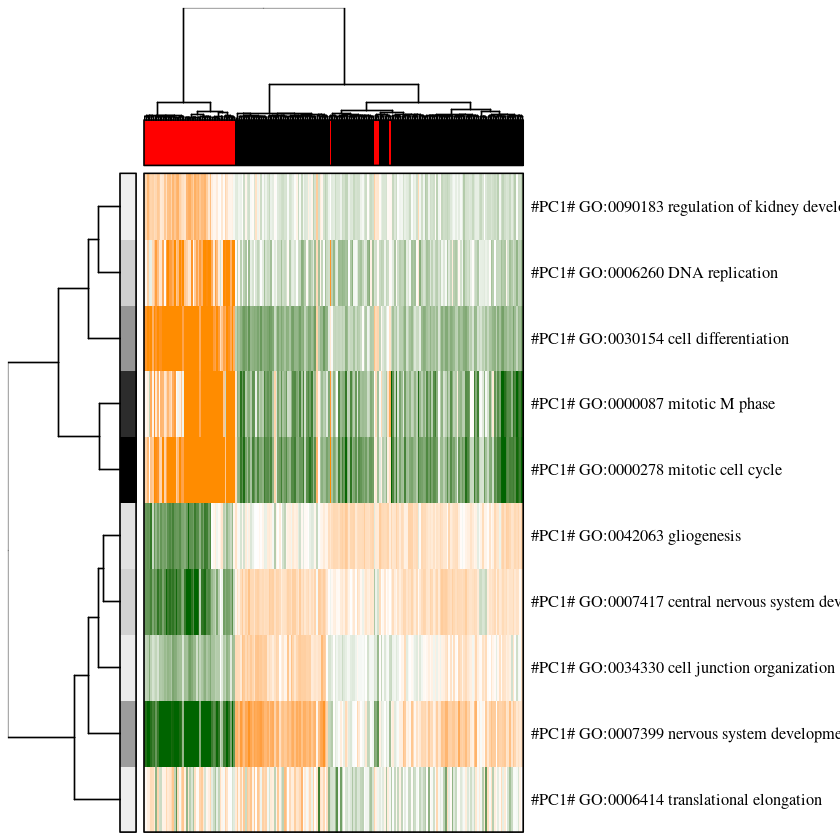

In [49]:
# reduce redundant aspects
tamr <- pagoda.reduce.loading.redundancy(tam, pwpca, clpca)
tamr2 <- pagoda.reduce.redundancy(tamr, plot = FALSE)
# view final result
pagoda.view.aspects(tamr2, cell.clustering = hc, box = TRUE, labCol = NA, margins = c(0.5, 20), col.cols = rbind(sg), top=10)

clustering cells based on 665 genes and 943 aspect patterns


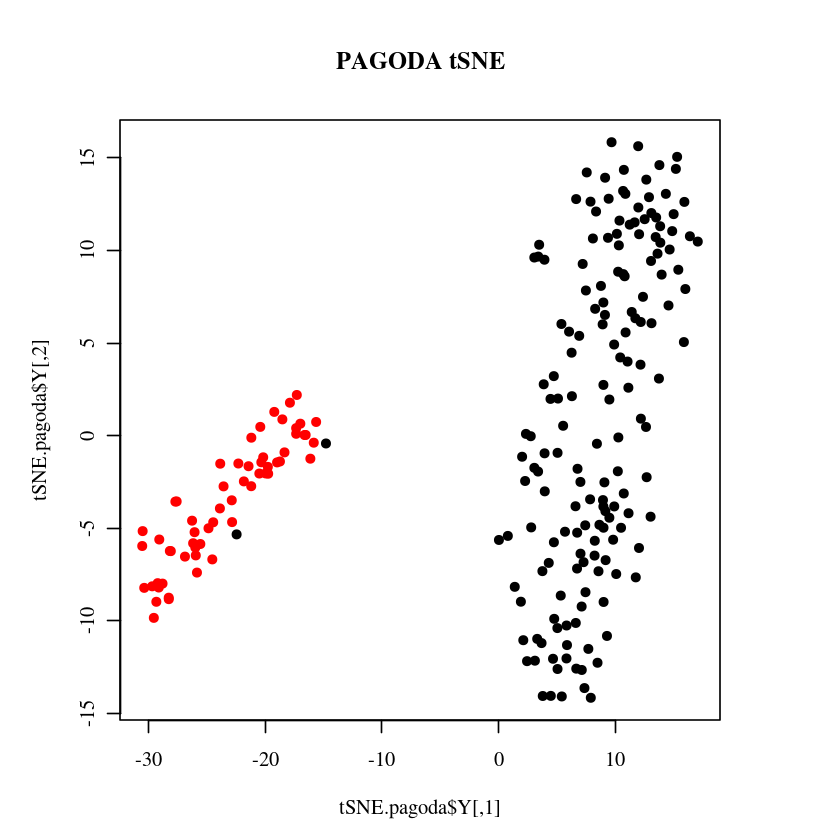

In [50]:
library(Rtsne)
# recalculate clustering distance .. we'll need to specify return.details=T
cell.clustering <- pagoda.cluster.cells(tam, varinfo, include.aspects=TRUE, verbose=TRUE, return.details=T)

# fix the seed to ensure reproducible results
set.seed(0)
tSNE.pagoda <- Rtsne(cell.clustering$distance, is_distance=TRUE, perplexity=10)

# plot
par(mfrow=c(1,1), mar = rep(5,4))
plot(tSNE.pagoda$Y, col=sg, pch=16, main='PAGODA tSNE')

In [52]:
tSNE.pagoda$Y

15.2848064,15.05122185
15.1778812,14.40071527
11.3976722,6.67750327
-22.2882049,-1.50142741
10.6747072,8.72202378
6.7560620,-1.78554828
10.4128520,4.22420607
13.0904547,6.07255162
13.0490327,9.43126492
5.0455503,-0.92439422
3.0580482,-1.73418324


In [51]:
# compile a browsable app
app <- make.pagoda.app(tamr2, tam, varinfo, go.env, pwpca, clpca, col.cols = rbind(sg), cell.clustering = hc, title = "Camp", embedding = tSNE.pagoda$Y)
# show app in the browser (port 1468)
show.app(app, "Camp", browse = TRUE, port = 1468) 

ERROR: Error in make.pagoda.app(tamr2, tam, varinfo, go.env, pwpca, clpca, col.cols = rbind(sg), : unused argument (embedding = tSNE.pagoda$Y)


[1] -4.346477  3.805928

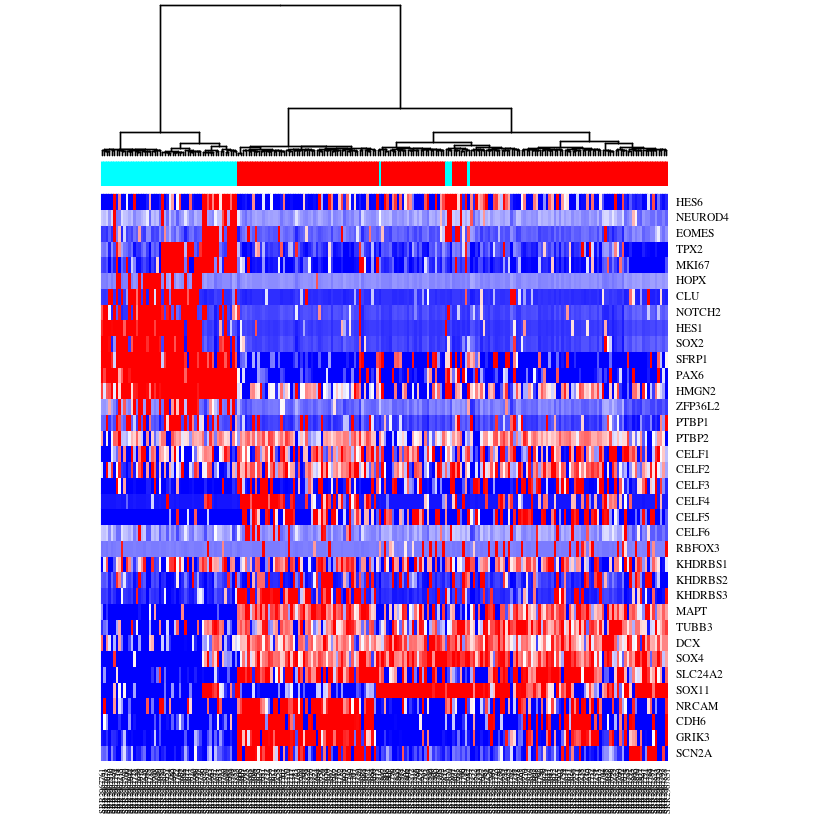

In [53]:
# visualize a few known markers
markers <- c(
    "SCN2A","GRIK3","CDH6","NRCAM","SOX11",
    "SLC24A2", "SOX4", "DCX", "TUBB3","MAPT",
    "KHDRBS3",  "KHDRBS2", "KHDRBS1", "RBFOX3",
    "CELF6", "CELF5", "CELF4", "CELF3", "CELF2", "CELF1",
    "PTBP2", "PTBP1", "ZFP36L2",
    "HMGN2", "PAX6", "SFRP1",
    "SOX2", "HES1", "NOTCH2", "CLU","HOPX",
    "MKI67","TPX2",
    "EOMES", "NEUROD4","HES6"
    )
# heatmap for subset of gene markers
mat.sub <- varinfo$mat[markers,]
range(mat.sub)

## [1] -4.346477  3.805928

mat.sub[mat.sub < -1] <- -1
mat.sub[mat.sub > 1] <- 1
heatmap(mat.sub[,hc$labels], Colv=as.dendrogram(hc), Rowv=NA, scale="none", col=colorRampPalette(c("blue", "white", "red"))(100), ColSideColors=rainbow(2)[sg])

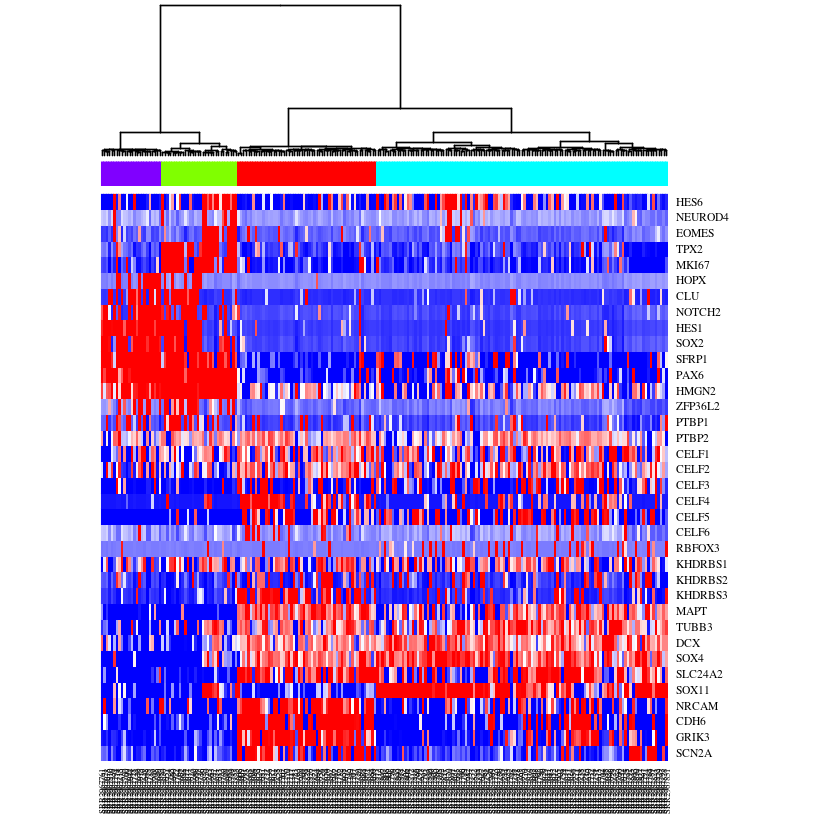

In [54]:
sg2 <- as.factor(cutree(hc, k=4))
names(sg2) <- hc$labels
heatmap(mat.sub[,hc$labels], Colv=as.dendrogram(hc), Rowv=NA, scale="none", col=colorRampPalette(c("blue", "white", "red"))(100), ColSideColors=rainbow(4)[sg2])

# Differential expression analysis

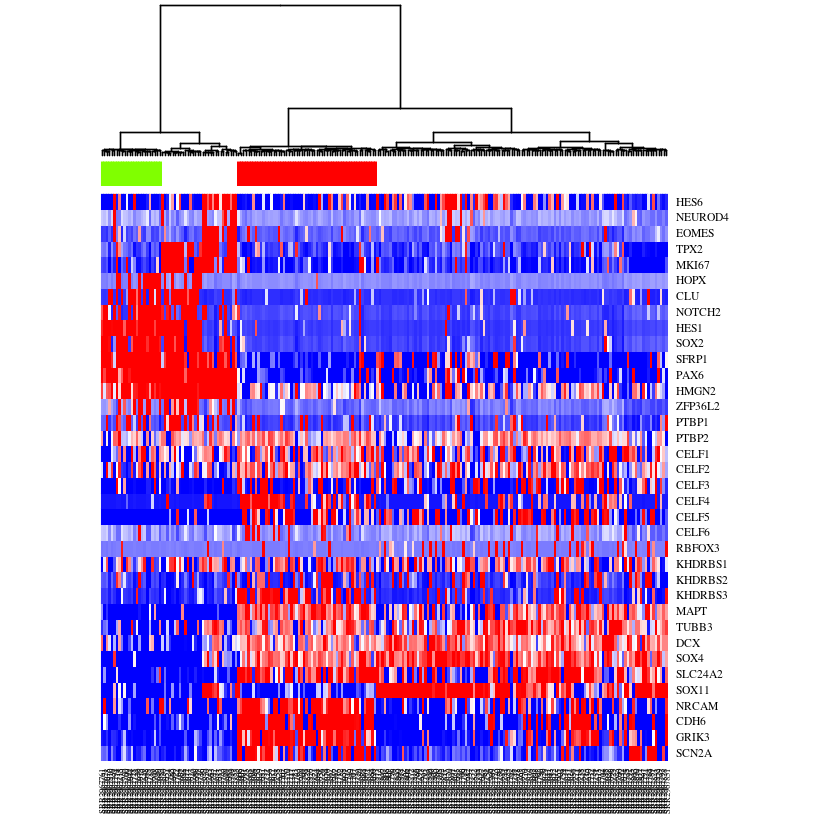

In [55]:
test <- as.character(sg2)
test[test==2] <- NA; test[test==3] <- NA
test <- as.factor(test)
names(test) <- names(sg2)
heatmap(mat.sub[,hc$labels], Colv=as.dendrogram(hc), Rowv=NA, scale="none", col=colorRampPalette(c("blue", "white", "red"))(100), ColSideColors=rainbow(4)[test])

In [56]:
# estimate gene expression prior
prior <- scde.expression.prior(models = knn, counts = cd, length.out = 400, show.plot = FALSE)


In [57]:
# run differential expression tests on a subset of genes (to save time)
vi <- c("BCL11B", "CDH6", "CNTNAP2", "GRIK3", "NEUROD6", "RTN1", "RUNX1T1", "SERINC5", "SLC24A2", "STMN2", "AIF1L", "ANP32E", "ARID3C", "ASPM", "ATP1A2", "AURKB", "AXL", "BCAN", "BDH2", "C12orf48")
ediff <- scde.expression.difference(knn, cd[vi,], prior, groups = test, n.cores = 1, verbose = 1)


comparing groups:

 1  4 
55 24 
calculating difference posterior
summarizing differences


In [58]:
# top upregulated genes (tail would show top downregulated ones)
head(ediff[order(abs(ediff$Z), decreasing = TRUE), ], )

,lb,mle,ub,ce,Z,cZ
STMN2,2.348161,3.224808,7.201028,2.348161,7.160400,6.845606
CDH6,7.075793,10.081439,10.519763,7.075793,7.151769,6.845606
CNTNAP2,2.379470,3.287426,8.453381,2.379470,7.112174,6.845606
RUNX1T1,1.972455,2.692558,7.514116,1.972455,6.620798,6.378670
ATP1A2,-10.050130,-9.236101,-7.639351,-7.639351,-6.539433,-6.328841
ARID3C,-8.923013,-7.326263,-5.009411,-5.009411,-6.299195,-6.109839


,lb,mle,ub,ce,Z,cZ
NEUROD6,1.721985,2.598632,7.388881,1.721985,5.841628,5.841628


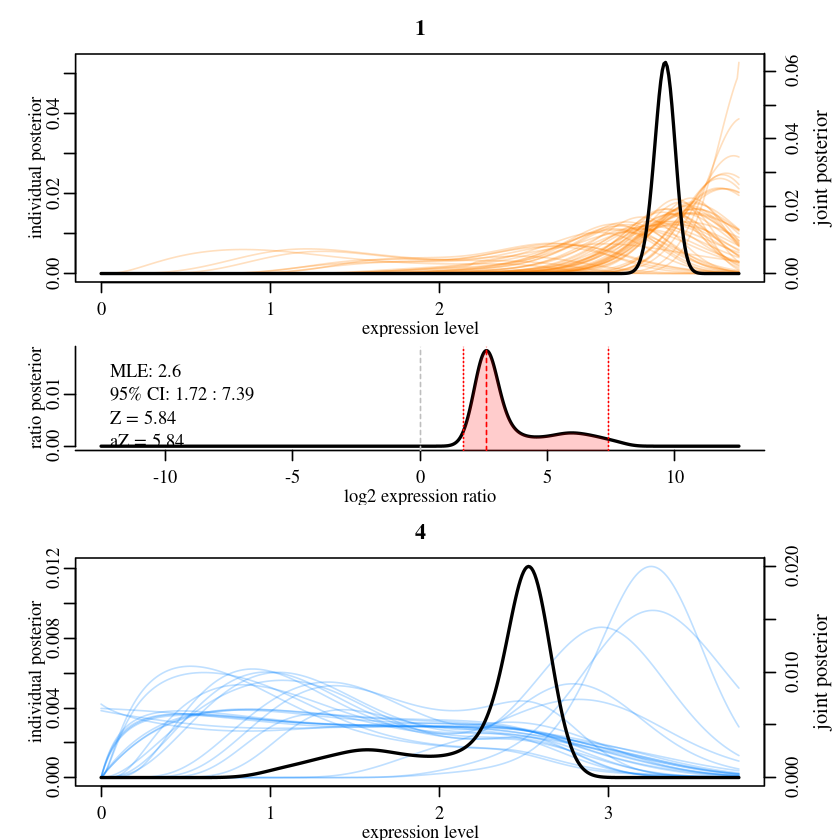

In [59]:
# visualize results for one gene
scde.test.gene.expression.difference("NEUROD6", knn, cd, prior, groups = test)

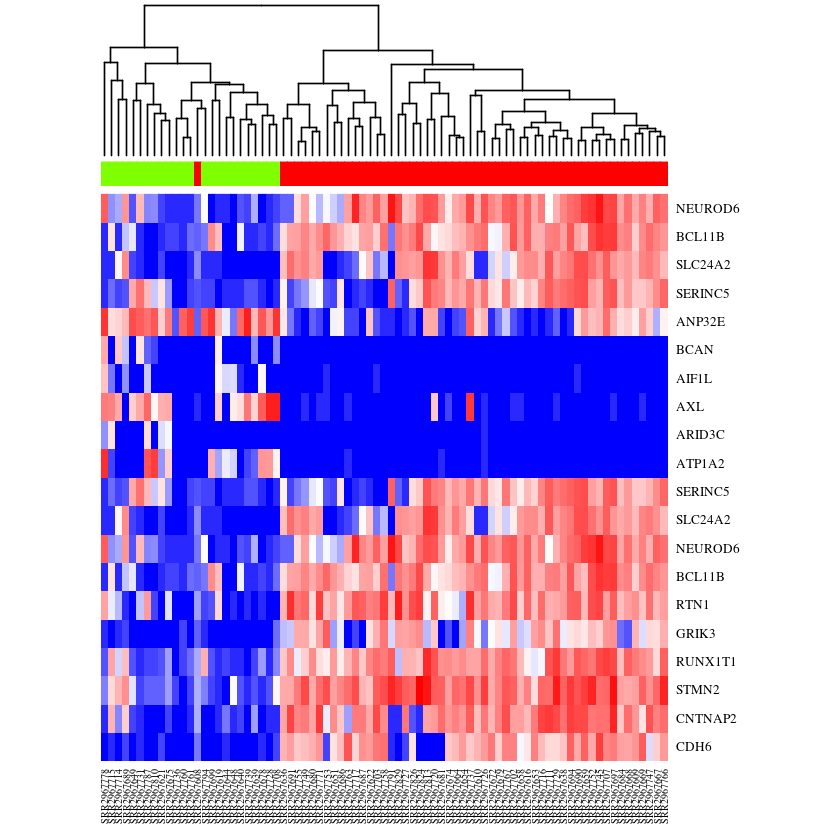

In [60]:
# heatmap
ediff.sig <- ediff[abs(ediff$cZ) > 1.96, ]
ediff.sig.up <- rownames(ediff.sig[order(ediff.sig$cZ, decreasing = TRUE), ])[1:10]
ediff.sig.down <- rownames(ediff.sig[order(ediff.sig$cZ, decreasing = FALSE), ])[1:10]
heatmap(mat[c(ediff.sig.up, ediff.sig.down), names(na.omit(test))], Rowv=NA, ColSideColors = rainbow(4)[test[names(na.omit(test))]],  col=colorRampPalette(c('blue', 'white', 'red'))(100), scale="none")

# Pseudo-time trajectory analysis

In [61]:
library('monocle')

Loading required package: Matrix
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:Matrix':

    colMeans, colSums, rowMeans, rowSums, which

The following object is masked from 'package:flexmix':

    unique

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, cbind, colMeans, colSums, colnames, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, lengths, mapply, match, mget, order, paste, pmax, pmax.int,
  

In [90]:
# Monocle takes as input fpkms
load('../scw/scw2016/data/fpm.RData')
expression.data <- fpm

In [91]:
head(fpm)

,SRR2967667,SRR2967668,SRR2967669,SRR2967670,SRR2967671,SRR2967672,SRR2967673,SRR2967674,SRR2967675,SRR2967676,⋯,SRR2967657,SRR2967658,SRR2967659,SRR2967660,SRR2967661,SRR2967662,SRR2967663,SRR2967664,SRR2967665,SRR2967666
1/2-SBSRNA4,0,0.0000,0,0,0,0,0,0,0,0.000000,,0,0.0000,0,0,0,0.00000,0.0000,7.128691,0,0
A1BG,0,0.0000,0,0,0,0,0,0,0,24.434533,,0,0.0000,0,0,0,0.00000,0.0000,14.257382,0,0
A1BG-AS1,0,0.0000,0,0,0,0,0,0,0,0.000000,,0,0.0000,0,0,0,0.00000,0.0000,0.000000,0,0
A1CF,0,0.0000,0,0,0,0,0,0,0,0.000000,,0,0.0000,0,0,0,0.00000,0.0000,0.000000,0,0
A2LD1,0,0.0000,0,0,0,0,0,0,0,0.000000,,0,0.0000,0,0,0,0.00000,0.0000,0.000000,0,0
A2M,0,133.0721,0,0,0,0,0,0,0,4.072422,,0,147.1688,0,0,0,26.60788,61.9082,35.643455,0,0


doc <- read.table("../GSE75140_hOrg.fetal.master.data.frame.txt",header = TRUE)
head(doc)

In [92]:
# create pheno data object 
pheno.data.df <- data.frame(type=sg[colnames(fpm)], pagoda=sg2[colnames(fpm)]) 
pd <- new('AnnotatedDataFrame', data = pheno.data.df) 

In [95]:
head(sg2)
head(sg)
head(pheno.data.df   )

SRR2967608 SRR2967609 SRR2967610 SRR2967611 SRR2967612 SRR2967613 
         1          1          1          2          3          3 
Levels: 1 2 3 4

SRR2967608 SRR2967609 SRR2967610 SRR2967611 SRR2967612 SRR2967613 
    neuron     neuron     neuron        npc     neuron     neuron 
Levels: neuron npc

,type,pagoda
SRR2967667,neuron,1
SRR2967668,neuron,1
SRR2967669,neuron,1
SRR2967670,npc,3
SRR2967671,npc,2
SRR2967672,neuron,1


In [123]:
# convert data object needed for Monocle
data <- newCellDataSet(expression.data, phenoData = pd)

Warning message in newCellDataSet(expression.data, phenoData = pd):
"Warning: featureData must contain a column verbatim named 'gene_short_name' for certain functions"Warning message in newCellDataSet(expression.data, phenoData = pd):
"Warning: featureData must contain a column verbatim named 'gene_short_name' for certain functions"Warning message in newCellDataSet(expression.data, phenoData = pd):
"Warning: featureData must contain a column verbatim named 'gene_short_name' for certain functions"

In [124]:
#data$Size_Factor=1

data <- estimateSizeFactors(data)

data$Size_Factor

length(data$pagoda)
data$pagoda

length(data$type)
data$type

In [107]:
markers

[1] "SCN2A"   "GRIK3"   "CDH6"    "NRCAM"   "SOX11"   "SLC24A2" "SOX4"   
 [8] "DCX"     "TUBB3"   "MAPT"    "KHDRBS3" "KHDRBS2" "KHDRBS1" "RBFOX3" 
[15] "CELF6"   "CELF5"   "CELF4"   "CELF3"   "CELF2"   "CELF1"   "PTBP2"  
[22] "PTBP1"   "ZFP36L2" "HMGN2"   "PAX6"    "SFRP1"   "SOX2"    "HES1"   
[29] "NOTCH2"  "CLU"     "HOPX"    "MKI67"   "TPX2"    "EOMES"   "NEUROD4"
[36] "HES6"

In [128]:
ordering.genes <- markers # Select genes used for ordering
data <- setOrderingFilter(data, ordering.genes) # Set list of genes for ordering

In [129]:
data <- reduceDimension(data, use_irlba = FALSE) # Reduce dimensionality




In [130]:
data <- setOrderingFilter(data, ordering.genes) # Set list of genes for ordering

In [131]:
set.seed(0) # Monocle is also stochastic
data <- orderCells(data, num_paths = 2, reverse = FALSE) # Order cells

Warning message:
"'plot_spanning_tree' is deprecated.
Use 'plot_cell_trajectory' instead.
See help("Deprecated")"

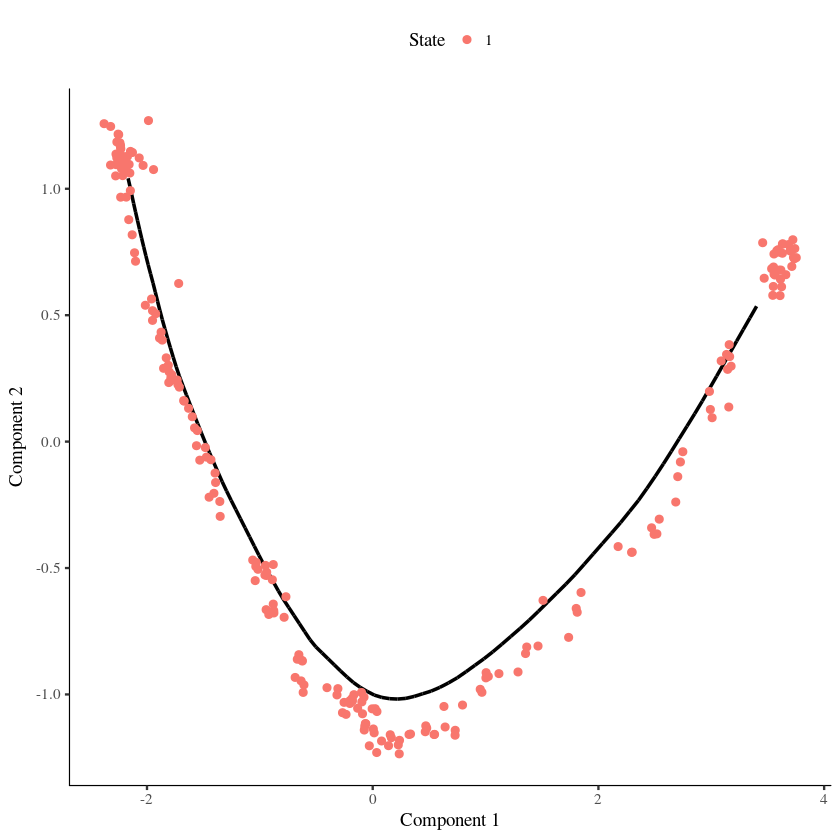

In [132]:
# Plot trajectory with inferred branches
plot_spanning_tree(data) 

Warning message:
"'plot_spanning_tree' is deprecated.
Use 'plot_cell_trajectory' instead.
See help("Deprecated")"

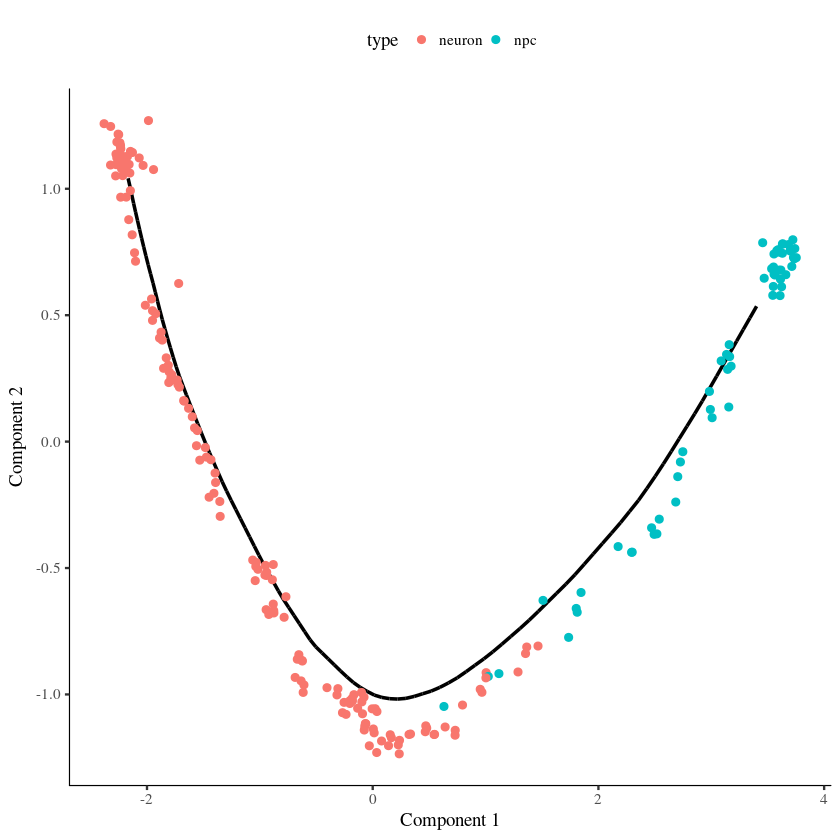

In [133]:
# Compare with previous annotations
plot_spanning_tree(data, color_by = "type") 

Warning message:
"'plot_spanning_tree' is deprecated.
Use 'plot_cell_trajectory' instead.
See help("Deprecated")"

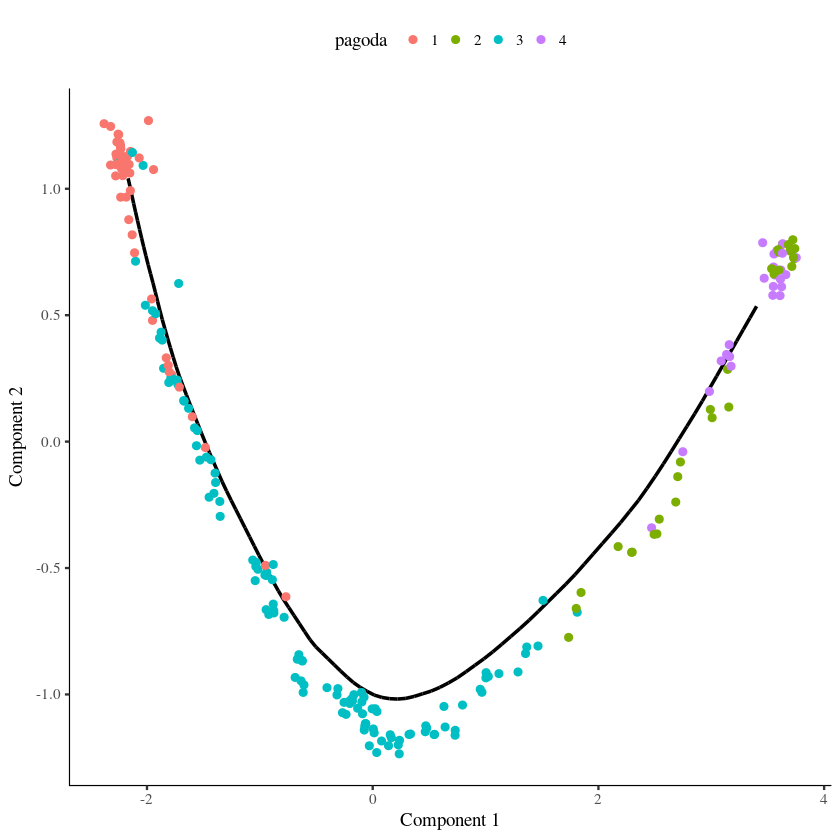

In [134]:
# Compare with PAGODA annotations
plot_spanning_tree(data, color_by = "pagoda") 

In [119]:
lung <- load_lung()

Removing 4 outliers


In [120]:
lung

CellDataSet (storageMode: environment)
assayData: 218 features, 185 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: SRR1033854_0 SRR1033855_0 ... SRR1034053_0 (185 total)
  varLabels: file total_mass ... num_genes_expressed (29 total)
  varMetadata: labelDescription
featureData
  featureNames: ENSMUSG00000000031.9 ENSMUSG00000000058.6 ...
    ENSMUSG00000096768.1 (218 total)
  fvarLabels: class_code nearest_ref_id ... use_for_ordering (10 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

Warning message:
"'plot_spanning_tree' is deprecated.
Use 'plot_cell_trajectory' instead.
See help("Deprecated")"

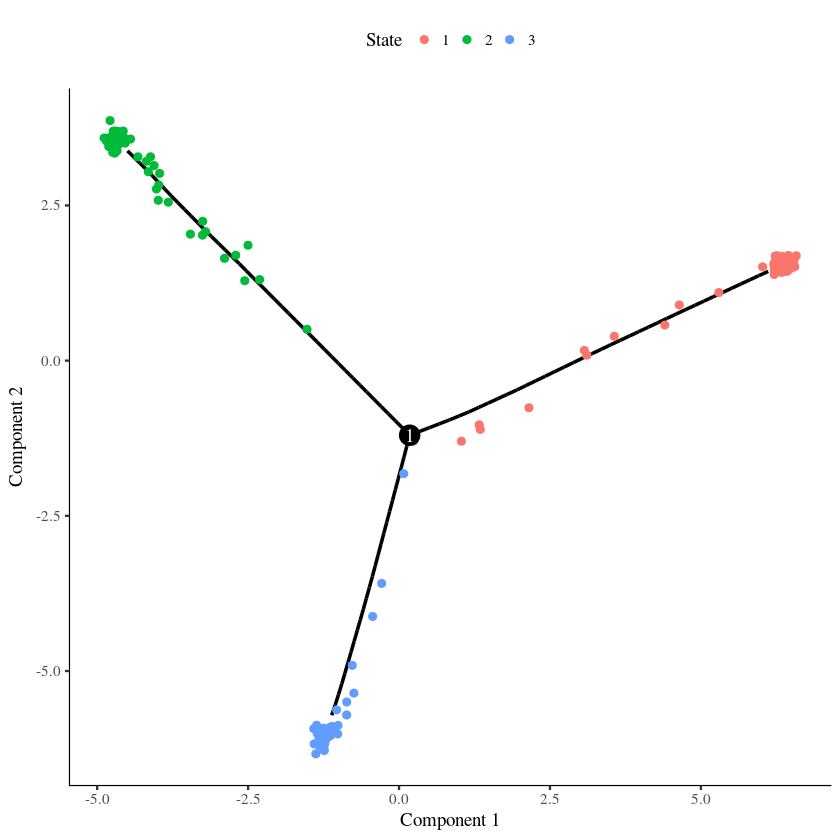

In [122]:
data <- reduceDimension(lung, use_irlba = FALSE) # Reduce dimensionality
set.seed(0) # Monocle is also stochastic
data <- orderCells(data, num_paths = 2, reverse = FALSE) # Order cells

# Plot trajectory with inferred branches
plot_spanning_tree(data) 